In [6]:
# Checkee.info Visa Case Visualization
# Analyzing waiting times for administrative processing cases

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv("data/checkee_data.csv")

# Convert check_date to datetime for time-series analysis
df['check_date'] = pd.to_datetime(df['check_date'], errors='coerce')

# Preview the data

print(f"Total records: {len(df)}")
print(f"Date range: {df['check_date'].min()} to {df['check_date'].max()}")
print(f"\nVisa types: {df['visa_type'].unique()}")
print(f"Columns: {df.columns}")
print(f"Entry types: {df['visa_entry'].unique()}")
print(f"Consulates: {df['US_consulate'].unique()}")

Total records: 4326
Date range: 2024-01-02 00:00:00 to 2026-01-08 00:00:00

Visa types: ['F1' 'H1' 'J1' 'L1' 'B2' 'H4' 'B1' 'O1' 'L2' 'F2' 'J2' 'O2']
Columns: Index(['ID', 'visa_type', 'visa_entry', 'US_consulate', 'major', 'status',
       'check_date', 'complete_date', 'waiting_days', 'details'],
      dtype='object')
Entry types: ['Renewal' 'New']
Consulates: ['BeiJing' 'Vancouver' 'ShangHai' 'HongKong' 'Others' 'GuangZhou' 'Europe'
 'ShenYang' 'Toronto' 'MexicoCity' 'Ottawa' 'Quebec' 'Calgary' 'Tijuana'
 'Montreal']


In [20]:
# Filtering Functions for Analysis

def filter_cases(df, visa_type=None, visa_entry=None, consulate=None, 
                 start_date=None, end_date=None, exclude_pending=True):
    """
    Filter visa cases based on multiple criteria.
    
    Parameters:
    -----------
    df : DataFrame - The full dataset
    visa_type : str - Filter by visa type (e.g., 'F1', 'H1')
    visa_entry : str - Filter by entry type ('New' or 'Renewal')
    consulate : str - Filter by US consulate location
    start_date : str - Start of date range (YYYY-MM-DD)
    end_date : str - End of date range (YYYY-MM-DD)
    exclude_pending : bool - Whether to exclude pending cases
    
    Returns:
    --------
    DataFrame with filtered cases
    """
    mask = pd.Series([True] * len(df))  # Start with all True
    if visa_type is not None:
        mask = mask & (df['visa_type'] == visa_type)
    if visa_entry is not None:
        mask = mask & (df['visa_entry'] == visa_entry)
    if consulate is not None:
        mask = mask & (df['US_consulate'] == consulate)
    if start_date is not None:
        mask = mask & (df['check_date'] >= start_date)
    if end_date is not None:
        mask = mask & (df['complete_date'] <= end_date)
    if exclude_pending:
        mask = mask & (df['status'] != 'Pending')  # Capital P to match data

    return df[mask]
    

# Test the filter
f1_renewal = filter_cases(df, visa_type='F1', visa_entry='Renewal')
print(f"F1 Renewal cases (excluding pending): {len(f1_renewal)}")

F1 Renewal cases (excluding pending): 587


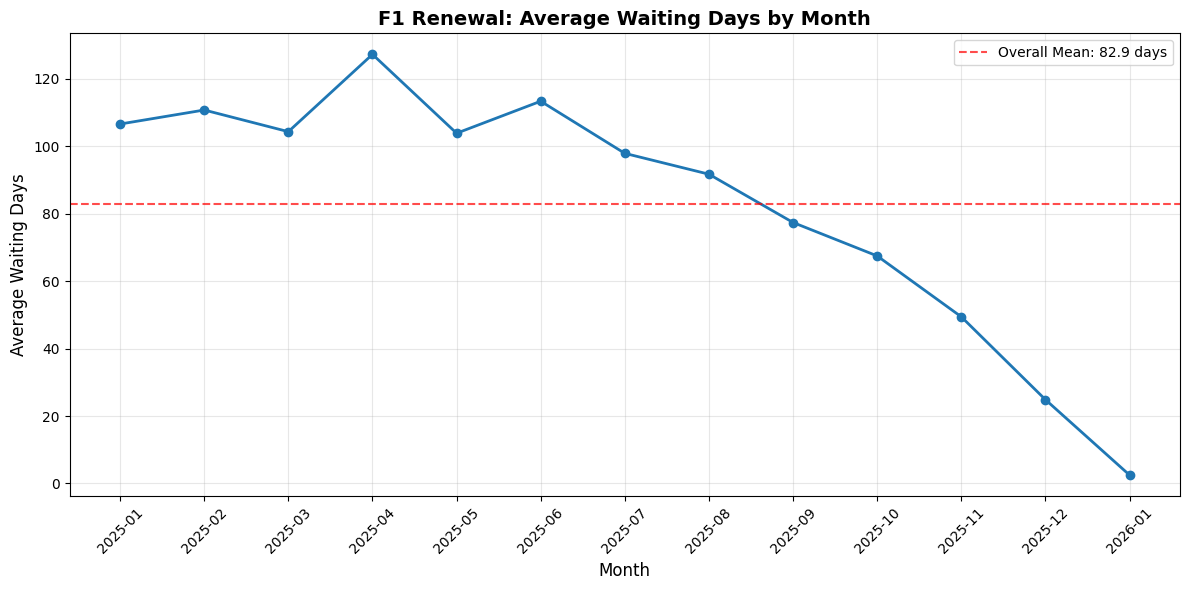

check_date
2025-01    106.629630
2025-02    110.785714
2025-03    104.363636
2025-04    127.294118
2025-05    103.895833
2025-06    113.392857
2025-07     97.928571
2025-08     91.740741
2025-09     77.416667
2025-10     67.500000
2025-11     49.444444
2025-12     24.870968
2026-01      2.500000
Freq: M, Name: waiting_days, dtype: float64

In [23]:
# Visualization 1: F1 Renewal Average Waiting Days Over Time
def plot_avg_waiting_by_month(filtered_df, title="Average Waiting Days by Month"):
    """Plot average waiting days grouped by month."""
    # Group by month and calculate mean waiting days
    monthly_avg = filtered_df.groupby(filtered_df['check_date'].dt.to_period('M'))['waiting_days'].mean()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot line chart
    months = monthly_avg.index.astype(str)
    ax.plot(months, monthly_avg.values, marker='o', linewidth=2, markersize=6)
    
    # Styling
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Average Waiting Days', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Add mean line
    overall_mean = monthly_avg.mean()
    ax.axhline(y=overall_mean, color='red', linestyle='--', alpha=0.7, 
               label=f'Overall Mean: {overall_mean:.1f} days')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return monthly_avg

# Usage (uncomment after implementing filter_cases):
f1_renewal = filter_cases(df, visa_type='F1', visa_entry='Renewal', start_date="2025-01-01", exclude_pending=False)
plot_avg_waiting_by_month(f1_renewal, "F1 Renewal: Average Waiting Days by Month")

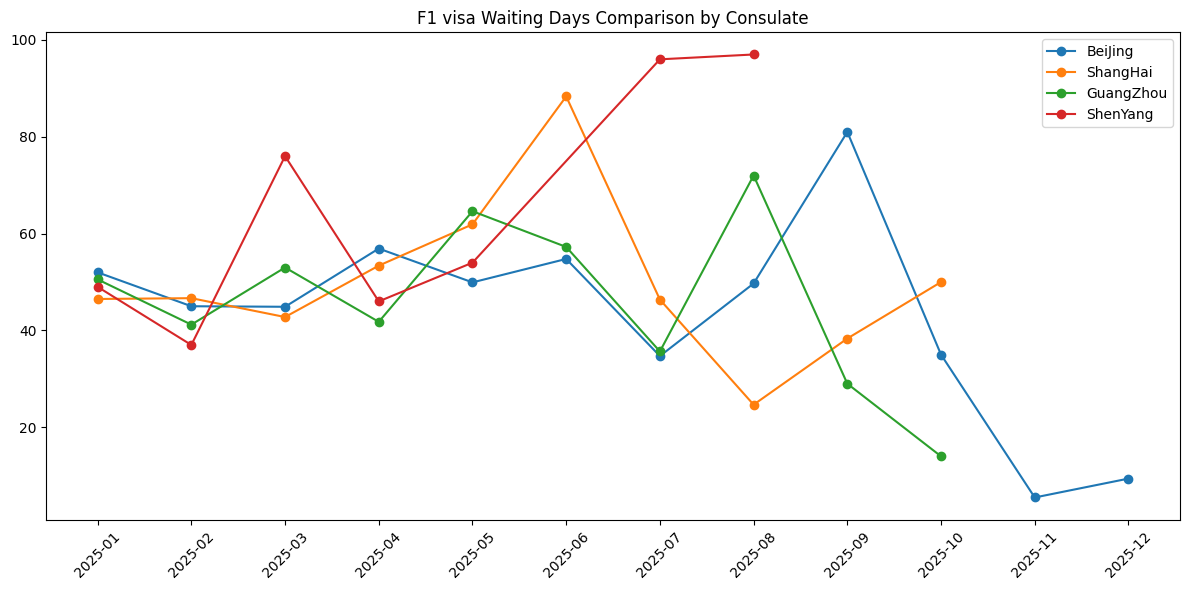

In [40]:
# Bonus: Compare multiple consulates
def plot_consulate_comparison(df, consulates=['BeiJing', 'ShangHai', 'GuangZhou']):
    fig, ax = plt.subplots(figsize=(12, 6))
    for consulate in consulates:
        filtered = filter_cases(df, start_date='2025-01-01', visa_type='F1', consulate=consulate)
        monthly = filtered.groupby(filtered['check_date'].dt.to_period('M'))['waiting_days'].mean()
        ax.plot(monthly.index.astype(str), monthly.values, marker='o', label=consulate)
    ax.legend()
    ax.set_title("F1 visa Waiting Days Comparison by Consulate")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_consulate_comparison(df, consulates=['BeiJing', 'ShangHai', 'GuangZhou', 'ShenYang'])

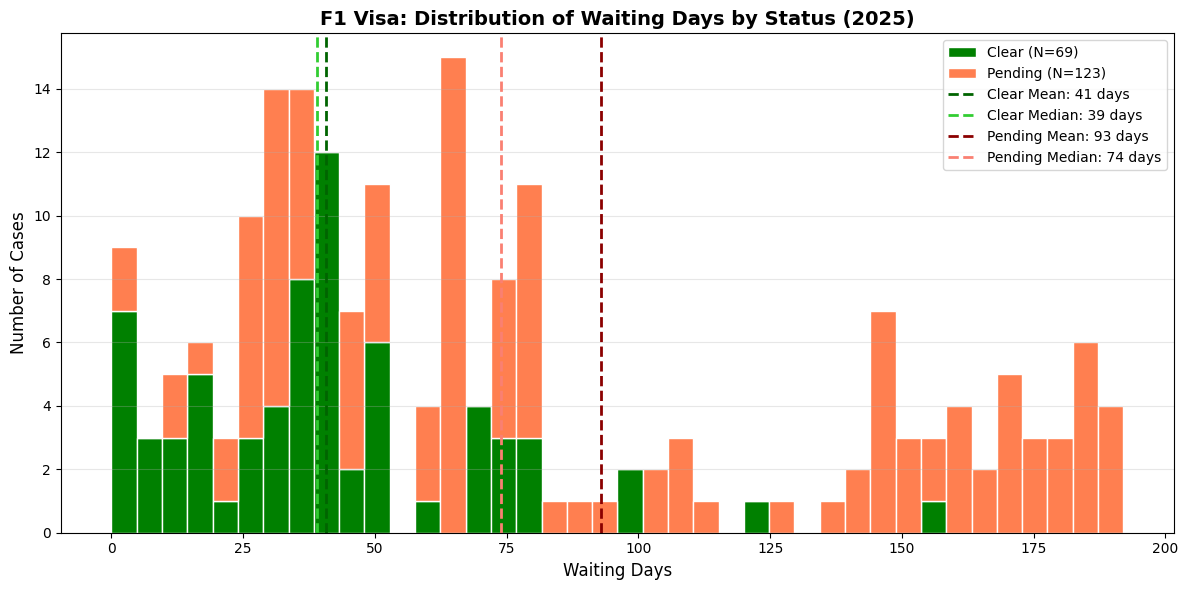

Clear cases: 69, Pending cases: 123


In [55]:
# Visualization 3: Distribution Histogram of Waiting Days (by Status)

def plot_waiting_distribution(filtered_df, title="Distribution of Waiting Days", max_days=200):
    """
    Plot histogram showing the distribution of waiting days, colored by case status.
    
    Parameters:
    -----------
    filtered_df : DataFrame - Filtered dataset (should include both Clear and Pending)
    title : str - Chart title
    max_days : int - Cap for x-axis (excludes extreme outliers from view)
    """
    # Filter out extreme values for better visualization
    df_capped = filtered_df[filtered_df['waiting_days'] <= max_days]
    
    # Separate data by status
    clear_data = df_capped[df_capped['status'] == 'Clear']['waiting_days']
    pending_data = df_capped[df_capped['status'] == 'Pending']['waiting_days']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Stacked histogram - Clear on bottom, Pending on top
    ax.hist([clear_data, pending_data], bins=40, stacked=True,
          color=['green', 'coral'], edgecolor='white',
          label=[f'Clear (N={len(clear_data)})', f'Pending (N={len(pending_data)})'])
    
    # Statistical reference lines for cleared cases
    if len(clear_data) > 0:
        ax.axvline(x=np.mean(clear_data), color='darkgreen', linestyle='--', linewidth=2, 
                   label=f'Clear Mean: {np.mean(clear_data):.0f} days')
        ax.axvline(x=np.median(clear_data), color='limegreen', linestyle='--', linewidth=2, 
                   label=f'Clear Median: {np.median(clear_data):.0f} days')
    
    # Statistical reference lines for pending cases
    if len(pending_data) > 0:
        ax.axvline(x=np.mean(pending_data), color='darkred', linestyle='--', linewidth=2, 
                   label=f'Pending Mean: {np.mean(pending_data):.0f} days')
        ax.axvline(x=np.median(pending_data), color='salmon', linestyle='--', linewidth=2, 
                   label=f'Pending Median: {np.median(pending_data):.0f} days')
        
    # Styling
    ax.set_xlabel('Waiting Days', fontsize=12)
    ax.set_ylabel('Number of Cases', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Clear cases: {len(clear_data)}, Pending cases: {len(pending_data)}")

# Test with F1 cases (include pending to see both colors)
f1_cases = filter_cases(df, start_date='2025-07-01', visa_type='F1', exclude_pending=False)
plot_waiting_distribution(f1_cases, "F1 Visa: Distribution of Waiting Days by Status (2025)")